In [330]:
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt

In [152]:
df = pd.read_csv("sales_data_v2/file6.csv")

In [153]:
df["Sale Date"] = pd.to_datetime(df["Sale Date"])
df["week"] = df["Sale Date"].dt.week
df["year"] = df["Sale Date"].dt.year
df["month"] = df["Sale Date"].dt.month
df["Amount"] = df["Sales Price"] * df["Sales Qty"]

In [154]:
def preprocess_data(df):
    # Keep rows where price > 0 
    df = df[df["Sales Price"] > 0]

    # Keep rows where MRP >= sell price
    df = df[df["MRP"] >= df["Sales Price"]]
    
    print('Number of missing values:\n',df.isnull().sum())
    df = df[~df["Category"].isnull()]
    
    # Remove returned items
    df = df[df["Sales Qty"]>0]

    df["Sale Date"] = pd.to_datetime(df["Sale Date"])
    return df

df = preprocess_data(df)

Number of missing values:
 SKU Code       0
Brand Code     0
Category       0
Bill Number    0
Store Code     0
Sale Date      0
Sale/Return    0
MRP            0
Sales Price    0
Sales Qty      0
week           0
year           0
month          0
Amount         0
dtype: int64


In [157]:
df.head()

,SKU Code,Brand Code,Category,Bill Number,Store Code,Sale Date,Sale/Return,MRP,Sales Price,Sales Qty,week,year,month,Amount,discount
0,SKU0729,BRAND017,Cat07,BILL02591,Store 5,2017-09-16,Sale,25.33,25.33,1,37,2017,9,25.33,0.0
1,SKU0624,BRAND027,Cat04,BILL02592,Store 5,2017-09-16,Sale,2.00,2.00,1,37,2017,9,2.00,0.0
2,SKU0650,BRAND027,Cat04,BILL02592,Store 5,2017-09-16,Sale,1.33,1.33,1,37,2017,9,1.33,0.0
3,SKU0730,BRAND018,Cat04,BILL02593,Store 5,2017-09-16,Sale,24.67,24.67,1,37,2017,9,24.67,0.0
4,SKU0731,BRAND018,Cat04,BILL02593,Store 5,2017-09-16,Sale,20.67,20.67,1,37,2017,9,20.67,0.0


In [156]:
df["discount"] = df.apply(lambda x: 100*(1 - x["Sales Price"]/x["MRP"]), axis=1)

In [158]:
def get_features_by_category(df):
    cat_feaures = pd.Series()
    cat_feaures["SKUs"] = len(df["SKU Code"].unique())
    cat_feaures["Brands"] = len(df["Brand Code"].unique())
    cat_feaures["Cat avg selling price"] = sum(df["Amount"])/sum(df["Sales Qty"])
#     cat_feaures["Cat dev selling price"] = 
#     cat_feaures["Max selling price"] = df["Sales Price"].max()
#     cat_feaures["Min selling price"] = df["Sales Price"].min()
    return cat_feaures

In [159]:
grouped_df = df.groupby("Category").apply(get_features_by_category)
grouped_df = grouped_df.reset_index()
grouped_df

,Category,SKUs,Brands,Cat avg selling price
0,Cat01,522.0,28.0,64.215815
1,Cat02,103.0,6.0,17.506802
2,Cat03,58.0,4.0,24.682842
3,Cat04,299.0,9.0,6.654645
4,Cat07,1002.0,14.0,19.828045
5,Cat08,43.0,4.0,8.145342


In [160]:
df = df.merge(grouped_df, on="Category", how="left")

In [161]:
df.keys()

Index(['SKU Code', 'Brand Code', 'Category', 'Bill Number', 'Store Code',
       'Sale Date', 'Sale/Return', 'MRP', 'Sales Price', 'Sales Qty', 'week',
       'year', 'month', 'Amount', 'discount', 'SKUs', 'Brands',
       'Cat avg selling price'],
      dtype='object')

In [187]:
df.head()

,SKU Code,Brand Code,Category,Bill Number,Store Code,Sale Date,Sale/Return,MRP,Sales Price,Sales Qty,week,year,month,Amount,discount,SKUs,Brands,Cat avg selling price
0,SKU0729,BRAND017,Cat07,BILL02591,Store 5,2017-09-16,Sale,25.33,25.33,1,37,2017,9,25.33,0.0,1002.0,14.0,19.828045
1,SKU0624,BRAND027,Cat04,BILL02592,Store 5,2017-09-16,Sale,2.00,2.00,1,37,2017,9,2.00,0.0,299.0,9.0,6.654645
2,SKU0650,BRAND027,Cat04,BILL02592,Store 5,2017-09-16,Sale,1.33,1.33,1,37,2017,9,1.33,0.0,299.0,9.0,6.654645
3,SKU0730,BRAND018,Cat04,BILL02593,Store 5,2017-09-16,Sale,24.67,24.67,1,37,2017,9,24.67,0.0,299.0,9.0,6.654645
4,SKU0731,BRAND018,Cat04,BILL02593,Store 5,2017-09-16,Sale,20.67,20.67,1,37,2017,9,20.67,0.0,299.0,9.0,6.654645


In [208]:
def get_season(month):
    return str(int((month + 1)%12 / 3))

[get_season(i) for i in range(12)]

['0', '0', '1', '1', '1', '2', '2', '2', '3', '3', '3', '0']

In [271]:
def weekly_features(df):
    series = pd.Series()
    series["weekly_SUs_sold"] = sum(df["Sales Qty"])
    series["weekly_discount"] = 100 * (1 - np.sum(df["Amount"])/np.sum(df["MRP"]*df["Sales Qty"]))
    series["season"] = get_season(df["month"].head(1))
    series["month"] = df["month"].max()
#     series["Average Selling Price"] = df["Cat avg selling price"].head(1).values[0]
    return series
    
temp_df = df.groupby(["Category", "year", "week"]).apply(weekly_features).reset_index()

D:\Anaconda\envs\py36\lib\site-packages\pandas\core\groupby\groupby.py:4315: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  stacked_values = np.vstack(map(np.asarray, values))


In [272]:
temp_df[["Category", "year", "week", "month", "weekly_discount", "season"]]

,Category,year,week,month,weekly_discount,season
0,Cat01,2017,1,1,0.000000,0
1,Cat01,2017,2,1,0.357615,0
2,Cat01,2017,3,1,0.000000,0
3,Cat01,2017,4,1,0.000000,0
4,Cat01,2017,5,2,0.000000,0
5,Cat01,2017,6,2,0.000000,1
6,Cat01,2017,7,2,0.000000,1
7,Cat01,2017,8,2,0.000000,1
8,Cat01,2017,9,3,0.000000,1
9,Cat01,2017,10,3,0.000000,1


In [273]:
# X_df = pd.get_dummies(temp_df[["Category", "year", "week"]].astype(str))
# X_df.keys()

In [274]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import LabelEncoder

In [348]:
from xgboost import XGBRegressor

In [275]:
le = LabelEncoder()
temp_df["Category"] = le.fit_transform(temp_df["Category"])

In [311]:
t_df = temp_df[["Category", "year", "week", "month", "season"]].astype("category")
t_df["weekly_discount"] = temp_df["weekly_discount"]
t_df["qty sold"] = temp_df["weekly_SUs_sold"]

In [385]:
features = ['Category', 'year', 'week', 'month', 'season', 'weekly_discount']

In [386]:
X = np.array(t_df[features].values)
y = np.array(t_df["qty sold"])

In [387]:
X.shape, y.shape

((283, 6), (283,))

In [ ]:
def train_regressor(regressor, X, y):
    regressor.fit(X, y)
    print(regressor.feature_importances_)
    print(regressor.score(X,y))
    return regressor

In [419]:
rf = RandomForestRegressor(n_estimators=50, max_depth=2)
xgb = XGBRegressor( learning_rate=1, n_estimators=50)

In [390]:
rf = train_regressor(rf, X, y)

[0.86006829 0.         0.03070348 0.         0.00235748 0.10687074]
0.48564157700439686


In [420]:
xgb = train_regressor(xgb, X, y)

[0.3125     0.05654762 0.33333334 0.0297619  0.04464286 0.22321428]
0.9635511329274355


In [421]:
y_pred = xgb.predict(X)

In [443]:
t_df["pred"] = list(map(lambda x: max(x,0), y_pred))

In [444]:
categories = df["Category"].unique().tolist()
categories.sort()
categories

[0, 1, 2, 3, 4, 5]

In [445]:
t_df.head()

,Category,year,week,month,season,weekly_discount,qty sold,pred
0,0,2017,1,1,0,0.000000,31.0,31.483223
1,0,2017,2,1,0,0.357615,55.0,57.823784
2,0,2017,3,1,0,0.000000,71.0,55.455853
3,0,2017,4,1,0,0.000000,48.0,47.274490
4,0,2017,5,2,0,0.000000,36.0,47.755833


In [451]:
forecast_df = t_df[t_df["year"]==2017]
forecast_df["year"] = 2018
forecast_df["weekly_discount"] = 0
forecast_df = forecast_df[features]

D:\Anaconda\envs\py36\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
D:\Anaconda\envs\py36\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [452]:
forecast_df.keys()

Index(['Category', 'year', 'week', 'month', 'season', 'weekly_discount'], dtype='object')

In [453]:
forecast_df["pred"] = xgb.predict(np.array(forecast_df.values))
forecast_df["pred"] = forecast_df["pred"].apply(lambda x: max(0,x))

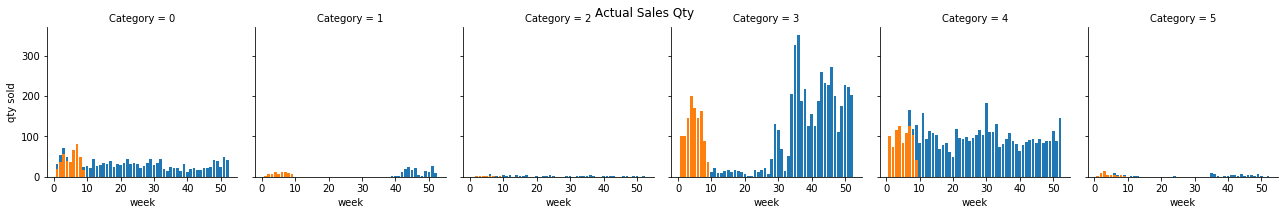

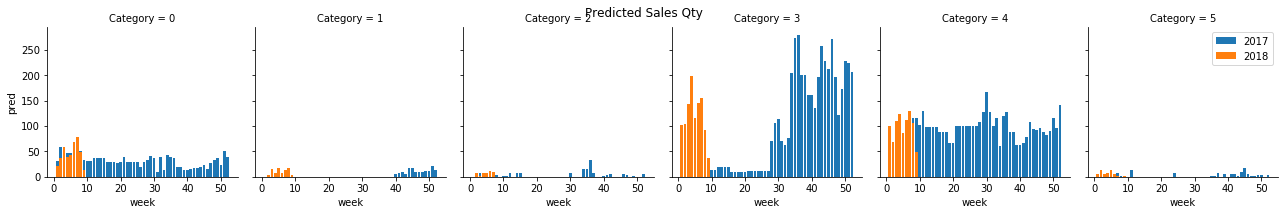

In [454]:
g = sns.FacetGrid(t_df, col="Category", hue="year", margin_titles=True)
g.map(plt.bar, "week", "qty sold")
g.fig.suptitle("Actual Sales Qty")

g = sns.FacetGrid(t_df, col="Category", hue="year", margin_titles=True)
g.map(plt.bar, "week", "pred")
g.fig.suptitle("Predicted Sales Qty")
plt.legend()

#### Next year Forecast at zero discount

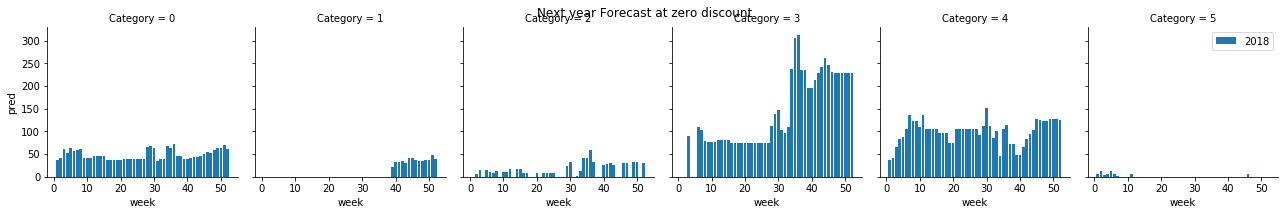

In [455]:
g = sns.FacetGrid(forecast_df, col="Category", hue="year", margin_titles=True)
g.map(plt.bar, "week", "pred")
g.fig.suptitle("Next year Forecast at zero discount")
plt.legend()